In [2]:
import nltk
import os, glob, math, time
import pandas as pd, numpy as np
from tqdm import tqdm
import requests
from urllib.parse import urlparse
import cv2
from PIL import Image
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
import joblib
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.utils import shuffle
from concurrent.futures import ProcessPoolExecutor, as_completed
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

data = 'dataset'  
os.makedirs(data, exist_ok=True)
traincsv = os.path.join(data, 'train.csv')

train_df = pd.read_csv(traincsv)
df = pd.read_csv(traincsv)

def download_image(url, out_path, timeout=10):
    try:
        resp = requests.get(url, timeout=timeout)
        if resp.status_code == 200 and resp.content:
            with open(out_path, 'wb') as f:
                f.write(resp.content)
            return True, None
        else:
            return False, f"status_{resp.status_code}"
    except Exception as e:
        return False, str(e)
        
IMG_DIR = os.path.join(data, 'images')
downloaded = []

for filepath in glob.glob(os.path.join(IMG_DIR, '*')):
    filename = os.path.splitext(os.path.basename(filepath))[0]
    try:
        idx = int(filename)
    except ValueError:
        idx = filename      
    downloaded.append((idx, filepath))

print("Existing images loaded:", len(downloaded))

Existing images loaded: 76998


In [3]:
def read_image_rgb(path, target_size=None):
    try:
        img = Image.open(path).convert('RGB')
        if target_size is not None:
            img = img.resize(target_size)
        return np.array(img)
    except:
        return None

def is_blurry(img, threshold=100):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm < threshold

akaze = cv2.AKAZE_create()

def extract_akaze_descriptors_from_path(path):
    img = read_image_rgb(path)
    if img is None or is_blurry(img):
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kps, des = akaze.detectAndCompute(gray, None)
    return des

In [5]:
N = 1024
BATCH_SIZE = 1500

kmeans = MiniBatchKMeans(n_clusters=N, random_state=42, batch_size=4096)
desc_buffer = []

for start in range(0, len(downloaded), BATCH_SIZE):
    batch = downloaded[start:start+BATCH_SIZE]
    sampled_descs = []
    for idx, path in batch:
        des = extract_akaze_descriptors_from_path(path)
        if des is None or len(des) == 0:
            continue
        if des.shape[0] > 256:
            perm = np.random.choice(des.shape[0], 256, replace=False)
            sampled_descs.append(des[perm])
        else:
            sampled_descs.append(des)
    if len(sampled_descs) < 20:
        continue
    all_des = np.vstack(sampled_descs)
    kmeans.partial_fit(all_des)
    print(f"Updated KMeans batch {start//BATCH_SIZE+1}")

joblib.dump(kmeans, os.path.join(data, 'models', 'kmeans1_bovw.joblib'))

Updated KMeans batch 1
Updated KMeans batch 2
Updated KMeans batch 3
Updated KMeans batch 4
Updated KMeans batch 5
Updated KMeans batch 6
Updated KMeans batch 7
Updated KMeans batch 8
Updated KMeans batch 9
Updated KMeans batch 10
Updated KMeans batch 11
Updated KMeans batch 12
Updated KMeans batch 13
Updated KMeans batch 14
Updated KMeans batch 15
Updated KMeans batch 16
Updated KMeans batch 17
Updated KMeans batch 18
Updated KMeans batch 19
Updated KMeans batch 20
Updated KMeans batch 21
Updated KMeans batch 22
Updated KMeans batch 23
Updated KMeans batch 24
Updated KMeans batch 25
Updated KMeans batch 26
Updated KMeans batch 27
Updated KMeans batch 28
Updated KMeans batch 29
Updated KMeans batch 30
Updated KMeans batch 31
Updated KMeans batch 32
Updated KMeans batch 33
Updated KMeans batch 34
Updated KMeans batch 35
Updated KMeans batch 36
Updated KMeans batch 37
Updated KMeans batch 38
Updated KMeans batch 39
Updated KMeans batch 40
Updated KMeans batch 41
Updated KMeans batch 42
U

['dataset\\models\\kmeans1_bovw.joblib']

In [6]:
def descriptors_to_bovw_hist(descriptors, kmeans):
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(kmeans.n_clusters, dtype=float)
    labels = kmeans.predict(descriptors)
    hist, _ = np.histogram(labels, bins=np.arange(kmeans.n_clusters+1))
    hist = hist.astype(float)
    if hist.sum() > 0:
        hist /= hist.sum()
    return hist

In [ ]:
features_db = []
ids_db = []

for idx, path in tqdm(downloaded, desc="Extracting features"):
    des = extract_akaze_descriptors_from_path(path)
    hist = descriptors_to_bovw_hist(des, kmeans)
    if hist is not None:
        features_db.append(hist)
        ids_db.append(idx)

features_db = np.vstack(features_db)
features_db = normalize(features_db, norm='l2')


Extracting features: 100%|██████████| 76998/76998 [6:06:09<00:00,  3.50it/s]   


NameError: name 'MODEL_DIR' is not defined

In [8]:
os.makedirs('dataset/models', exist_ok=True)
joblib.dump((features_db, ids_db), 'features_db1.joblib')

['features_db1.joblib']

In [9]:
def find_most_similar(query_path, features_db, ids_db, top_k=5, n_samples=3):
    des = extract_akaze_descriptors_from_path(query_path)
    if des is None or len(des) < 20:
        return []
    
    hists = []
    for _ in range(n_samples):
        if des.shape[0] > 64:
            perm = np.random.choice(des.shape[0], 64, replace=False)
            sampled_des = des[perm]
            hist = descriptors_to_bovw_hist(sampled_des, kmeans)
        else:
            hist = descriptors_to_bovw_hist(des, kmeans)
        hists.append(hist)
    
    hist = np.mean(hists, axis=0).reshape(1, -1)
    hist = normalize(hist, norm='l2')
    
    sims = cosine_similarity(hist, features_db)[0]
    top_indices = sims.argsort()[::-1][:top_k]
    results = [(ids_db[i], sims[i]) for i in top_indices]
    return results

In [12]:
checkpoint_path = 'dataset/models/eval_checkpoint.joblib'
results_path = 'dataset/models/eval_results.joblib'

top1_correct = 0
top5_correct = 0
start_idx = 0

if os.path.exists(checkpoint_path):
    print(f"[INFO] Melanjutkan dari checkpoint: {checkpoint_path}")
    checkpoint = joblib.load(checkpoint_path)
    top1_correct = checkpoint['top1_correct']
    top5_correct = checkpoint['top5_correct']
    start_idx = checkpoint['last_idx'] + 1
else:
    print("[INFO] Tidak ada checkpoint, mulai dari awal")

for i in tqdm(range(start_idx, len(downloaded)), desc="Evaluating Top-K"):
    idx, path = downloaded[i]

    if idx not in df.index:
        continue
    
    gt_product_id = df.loc[idx, 'sample_id']
    top_results = find_most_similar(path, features_db, ids_db, top_k=5)
    if not top_results: 
        continue
    top_ids = [r[0] for r in top_results]
    
    if idx == top_ids[0]:
        top1_correct += 1
    if idx in top_ids:
        top5_correct += 1

    if (i + 1) % 5000 == 0 or i == len(downloaded) - 1:
        joblib.dump({
            'top1_correct': top1_correct,
            'top5_correct': top5_correct,
            'last_idx': i
        }, checkpoint_path)
        print(f"[CHECKPOINT] Disimpan di iterasi {i + 1}")

n_samples = len(downloaded)
top1_acc = top1_correct / n_samples
top5_acc = top5_correct / n_samples

joblib.dump({
    'Top-1 accuracy': top1_acc,
    'Top-5 accuracy': top5_acc
}, results_path)

print("\n=== HASIL AKHIR ===")
print("Top-1 accuracy:", top1_acc)
print("Top-5 accuracy:", top5_acc)


if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
    print("[INFO] Checkpoint dihapus setelah selesai.")   


[INFO] Tidak ada checkpoint, mulai dari awal


Evaluating Top-K:   6%|▋         | 5000/76998 [54:03<11:45:24,  1.70it/s]

[CHECKPOINT] Disimpan di iterasi 5000


Evaluating Top-K:  13%|█▎        | 10000/76998 [1:32:47<8:32:06,  2.18it/s]

[CHECKPOINT] Disimpan di iterasi 10000


Evaluating Top-K:  19%|█▉        | 15000/76998 [2:11:20<7:35:49,  2.27it/s] 

[CHECKPOINT] Disimpan di iterasi 15000


Evaluating Top-K:  26%|██▌       | 20000/76998 [2:50:13<6:58:30,  2.27it/s] 

[CHECKPOINT] Disimpan di iterasi 20000


Evaluating Top-K:  32%|███▏      | 25000/76998 [3:28:42<7:46:39,  1.86it/s] 

[CHECKPOINT] Disimpan di iterasi 25000


Evaluating Top-K:  39%|███▉      | 30000/76998 [4:07:27<5:37:02,  2.32it/s] 

[CHECKPOINT] Disimpan di iterasi 30000


Evaluating Top-K:  45%|████▌     | 35000/76998 [4:45:46<5:15:11,  2.22it/s]

[CHECKPOINT] Disimpan di iterasi 35000


Evaluating Top-K:  52%|█████▏    | 40000/76998 [5:24:22<4:06:30,  2.50it/s]

[CHECKPOINT] Disimpan di iterasi 40000


Evaluating Top-K:  71%|███████▏  | 55000/76998 [7:20:32<3:16:39,  1.86it/s]

[CHECKPOINT] Disimpan di iterasi 55000


Evaluating Top-K:  78%|███████▊  | 60000/76998 [7:59:09<2:40:57,  1.76it/s]

[CHECKPOINT] Disimpan di iterasi 60000


Evaluating Top-K:  84%|████████▍ | 65000/76998 [8:37:32<2:13:38,  1.50it/s]

[CHECKPOINT] Disimpan di iterasi 65000


Evaluating Top-K:  91%|█████████ | 70000/76998 [9:47:21<1:26:09,  1.35it/s]

[CHECKPOINT] Disimpan di iterasi 70000


Evaluating Top-K: 100%|██████████| 76998/76998 [10:59:03<00:00,  1.95it/s]  


=== HASIL AKHIR ===
Top-1 accuracy: 0.7307332657991117
Top-5 accuracy: 0.7730850151951999
[INFO] Checkpoint dihapus setelah selesai.


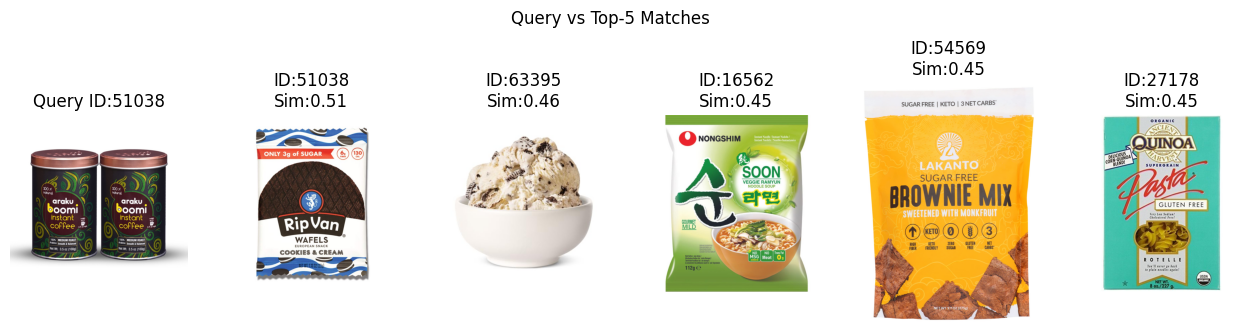

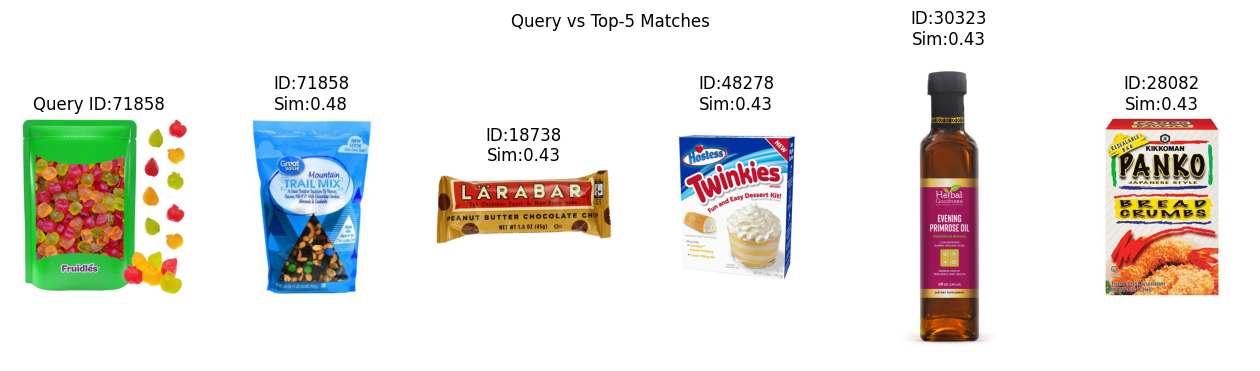

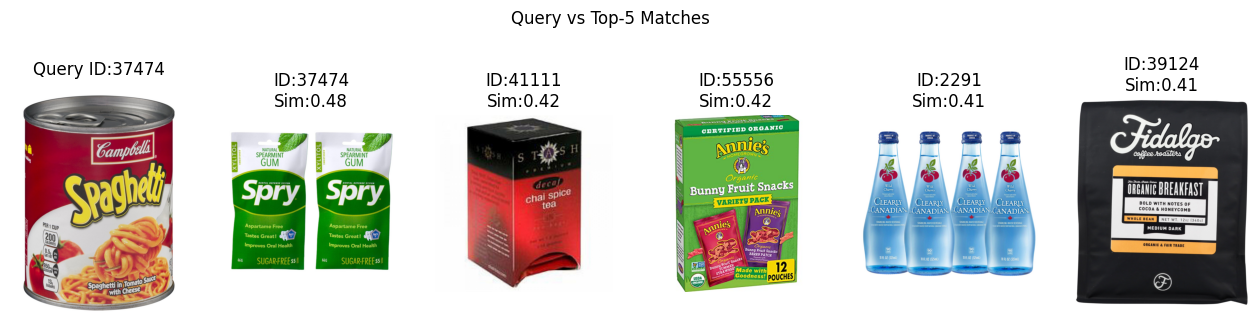

In [17]:
import random
sample_queries = random.sample(downloaded, min(3, len(downloaded)))

for query_idx, query_path in sample_queries:
    top_results = find_most_similar(query_path, features_db, ids_db, top_k=5)
    
    plt.figure(figsize=(16,4))
    query_img = Image.open(query_path).convert('RGB')
    plt.subplot(1,6,1)
    plt.imshow(query_img)
    plt.axis('off')
    plt.title(f"Query ID:{query_idx}")
    
    for i, (match_idx, sim) in enumerate(top_results):
        match_img = Image.open(downloaded[match_idx][1]).convert('RGB')
        plt.subplot(1,6,i+2)
        plt.imshow(match_img)
        plt.axis('off')
        plt.title(f"ID:{match_idx}\nSim:{sim:.2f}")
    
    plt.suptitle("Query vs Top-5 Matches")
    plt.show()